In [1]:
import numpy as np
import tensorflow as tf
import cv2
from random import shuffle
from os import listdir, path
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

In [28]:
train_data_directory = "./data/train"
validation_data_directory = "./data/dev"
IMG_SIZE = 64
CHANNELS = 1
class_size = 2
lr = 0.01

In [41]:
def label_data(img_name):
    """
    :param img_name: The image name
    :return: The image label
    """
    name = str(img_name)[:3]
    if name == "cat":
        return [1, 0]
    elif name == "dog":
        return [0, 1]

def create_data(img_dir, validation_data=False):
    """
    :param img_dir: The images directory
    :param validation_data: Flag to decide if data should be augmented for training
    :return: A list of all the image data
    """
    data = []
    for img in tqdm(listdir(img_dir)):
        label = label_data(img)
        img_path = path.join(img_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img1 = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        data.append([np.array(img1)/255, np.array(label)])
        if not validation_data:
            """
            Augment the training data by horizontally flipping each training example to 
            generate a "new" training example
            """
            img2 = cv2.flip(img1, 1)
            data.append([np.array(img2)/255, np.array(label)])
    
    shuffle(data)
    return data
    

In [42]:
train_data = create_data(train_data_directory)

100%|██████████| 20000/20000 [02:32<00:00, 131.29it/s]


In [43]:
validation_data = create_data(validation_data_directory, True)

100%|██████████| 5000/5000 [01:05<00:00, 76.22it/s] 


In [44]:
X_train = np.array([data[0] for data in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)
Y_train = np.array([data[1] for data in train_data]).reshape(-1, class_size)

X_train_mlp = np.array([data[0] for data in train_data]).reshape(-1, IMG_SIZE * IMG_SIZE * CHANNELS)

In [45]:
X_validation = np.array([data[0] for data in validation_data]).reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)
Y_validation = np.array([data[1] for data in validation_data]).reshape(-1, class_size)

X_validation_mlp = np.array([data[0] for data in validation_data]).reshape(-1, IMG_SIZE * IMG_SIZE * CHANNELS)

In [46]:
def mlp_model(input_shape, layer_sizes, dropout_rate=0.0):
    """
    Function to create and return a deep multilayer perceptron model for image classification
    :param input_shape: The shape of the input data
    :param layer_sizes: The number of units in the hidden and output layers
    :param dropout_rate: The dropout rate
    
    :return: An n-Hidden Layer MLP model
    """
    input_layer = tf.keras.Input(shape=input_shape)
    X = tf.keras.layers.Dense(layer_sizes[0])(input_layer)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(dropout_rate)(X)
    
    for layer_size in layer_sizes[1:-1]:
        X = tf.keras.layers.Dense(layer_size)(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Dropout(dropout_rate)(X)
        
    X = tf.keras.layers.Dense(layer_sizes[-1])(X)
    X = tf.keras.layers.BatchNormalization()(X)
    output = tf.keras.layers.Activation('softmax')(X)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
        
    return model

In [47]:
model = mlp_model((IMG_SIZE * IMG_SIZE * CHANNELS, ), [1500, 1500, 1000, 500, class_size], 0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense_31 (Dense)             (None, 1500)              6145500   
_________________________________________________________________
batch_normalization_31 (Batc (None, 1500)              6000      
_________________________________________________________________
activation_31 (Activation)   (None, 1500)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1500)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1500)              2251500   
_________________________________________________________________
batch_normalization_32 (Batc (None, 1500)              6000

In [49]:
history = model.fit(X_train_mlp, Y_train, batch_size=32, epochs=30)

Epoch 1/30
1250/1250 [==============================] - 725s 577ms/step - loss: 0.6612 - accuracy: 0.6064
Epoch 2/30
1250/1250 [==============================] - 564s 451ms/step - loss: 0.6415 - accuracy: 0.6293
Epoch 3/30
1250/1250 [==============================] - 520s 416ms/step - loss: 0.6311 - accuracy: 0.6408
Epoch 4/30
1250/1250 [==============================] - 513s 411ms/step - loss: 0.6225 - accuracy: 0.6514
Epoch 5/30
1250/1250 [==============================] - 493s 394ms/step - loss: 0.6134 - accuracy: 0.6617
Epoch 6/30
1250/1250 [==============================] - 471s 377ms/step - loss: 0.6018 - accuracy: 0.6740
Epoch 7/30
1250/1250 [==============================] - 468s 375ms/step - loss: 0.5896 - accuracy: 0.6839
Epoch 8/30
1250/1250 [==============================] - 472s 377ms/step - loss: 0.5724 - accuracy: 0.6995
Epoch 9/30
1250/1250 [==============================] - 506s 405ms/step - loss: 0.5538 - accuracy: 0.7138
Epoch 10/30
1250/1250 [=======================

In [54]:
predictions = model.predict(X_validation_mlp, batch_size=32)

In [56]:
correct = tf.equal(tf.math.argmax(predictions, axis=1), tf.math.argmax(Y_validation, axis=1))
validation_accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
print("Validation Accuracy = ", float(validation_accuracy) * 100, "%")

Validation Accuracy =  61.500000953674316 %


In [226]:
model.save("./models/mlp_model.h5")

In [107]:
n_row, n_col = 3, 3
samples = np.random.choice(len(X_validation_mlp), n_row * n_col, replace=False)

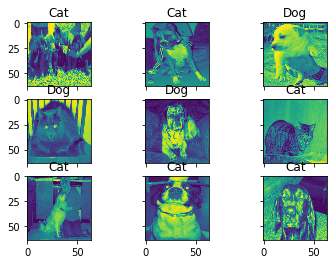

In [108]:
_, ax = plt.subplots(n_row, n_col)
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(X_validation_mlp[samples[i * n_col + j]].reshape(IMG_SIZE, IMG_SIZE))
        ax[i, j].label_outer()
        label = "Cat" if float(tf.math.argmax(predictions[samples[i * n_col + j]])) == 0.0 else "Dog"
        ax[i, j].set_title(label)
plt.show()

In [129]:
def simple_cnn_model(input_shape, n_conv_blocks, n_dense, n_classes, dropout_rate=0.0):
    """
    Function to create an return a convolutional neural network model for image classification
    :param input_shape: The image input shape
    :param n_conv_blocks: The number of convolution-maxpool blocks
    :param n_dense: The number of units in the dense layers
    :param n_classes: The number of output classes
    :param dropout_rate: The dropout rate
    
    :return: A CNN model
    """
    input_layer = tf.keras.Input(shape=input_shape)
    X = input_layer
    
    for i in range(n_conv_blocks):
        X = tf.keras.layers.Conv2D(32 * 2 ** i, 5, strides=(1, 1), padding='same')(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Dropout(dropout_rate)(X)
        X = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(X)
      
    X = tf.keras.layers.Flatten()(X)
    for n in n_dense:
        X = tf.keras.layers.Dense(n)(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Dropout(dropout_rate)(X)
    
    X = tf.keras.layers.Dense(n_classes)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    output = tf.keras.layers.Activation('softmax')(X)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [130]:
cnn_model = simple_cnn_model((IMG_SIZE, IMG_SIZE, 1, ), 3, [500, 500], 2, 0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.9, beta_2=0.999)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [131]:
cnn_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
batch_normalization_52 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_52 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        512

In [132]:
history = cnn_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 4039s 3s/step - loss: 0.5567 - accuracy: 0.7091
Epoch 2/10
1250/1250 [==============================] - 3572s 3s/step - loss: 0.4150 - accuracy: 0.8109
Epoch 3/10
1250/1250 [==============================] - 3677s 3s/step - loss: 0.3377 - accuracy: 0.8507
Epoch 4/10
1250/1250 [==============================] - 3687s 3s/step - loss: 0.2848 - accuracy: 0.8793
Epoch 5/10
1250/1250 [==============================] - 3615s 3s/step - loss: 0.2431 - accuracy: 0.8977
Epoch 6/10
1250/1250 [==============================] - 4092s 3s/step - loss: 0.2089 - accuracy: 0.9140
Epoch 7/10
1250/1250 [==============================] - 4019s 3s/step - loss: 0.1729 - accuracy: 0.9300
Epoch 8/10
1250/1250 [==============================] - 6062s 5s/step - loss: 0.1413 - accuracy: 0.9433
Epoch 9/10
1250/1250 [==============================] - 3866s 3s/step - loss: 0.1173 - accuracy: 0.9545
Epoch 10/10
1250/1250 [==============================] - 3675s 3

In [133]:
cnn_predictions = cnn_model.predict(X_validation, batch_size=32)

In [135]:
correct = tf.equal(tf.math.argmax(cnn_predictions, axis=1), tf.math.argmax(Y_validation, axis=1))
validation_accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
print("CNN Validation Accuracy = ", float(validation_accuracy) * 100, "%")

CNN Validation Accuracy =  85.51999926567078 %


In [254]:
cnn_model.save("./models/cnn_model.h5")

In [140]:
n_row, n_col = 3, 3
cnn_samples = np.random.choice(len(X_validation), n_row * n_col, replace=False)

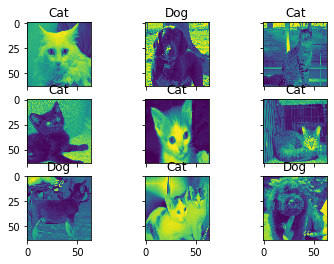

In [141]:
_, ax = plt.subplots(n_row, n_col)
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(X_validation[cnn_samples[i * n_col + j]].reshape(IMG_SIZE, IMG_SIZE))
        ax[i, j].label_outer()
        label = "Cat" if float(tf.math.argmax(predictions[cnn_samples[i * n_col + j]])) == 0.0 else "Dog"
        ax[i, j].set_title(label)
plt.show()

In [244]:
def residual_block(X, n_conv_layers, n_filters, filter_size, dropout_rate=0.0):
    """
    Function to create and return a residual block for a residual network model
    :param X: The input to the block
    :param n_conv_layers: The number of convolutional layers in the block
    :param n_filters: The number of filters in each convolutional layer
    :param filter_size: The filter size
    :param dropout_rate: The dropout rate

    :return: A residual block
    """
    assert (n_conv_layers >= 2), "A residual block should have at least 2 layers"
    X_copy = X

    if X_copy.shape[-1] != n_filters:
        X_copy = tf.keras.layers.Conv2D(n_filters, filter_size, padding='same', strides=(1, 1))(X_copy)
        X_copy = tf.keras.layers.BatchNormalization()(X_copy)

    for i in range(n_conv_layers):
        X = tf.keras.layers.Conv2D(n_filters, filter_size, padding='same', strides=(1, 1))(X)
        X = tf.keras.layers.BatchNormalization()(X)
        if i < n_conv_layers - 1:
            X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Add()([X_copy, X])
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(dropout_rate)(X)

    return X

In [247]:
def simple_residual_network(input_shape, res_block_sizes, n_dense, n_classes, dropout_rate=0.0):
    """
    Function to create and return a simple residual network model for image classification
    :param input_shape: The input shape
    :param res_block_sizes: A list containing the number of conv layers in each residual block
    :param n_dense: A list containing the number of units in each fully-connected/dense layer
    :param n_classes: The number of output classes
    :param dropout_rate: The dropout rate

    :return: A residual network model
    """
    input_layer = tf.keras.layers.Input(shape=input_shape)
    X = tf.keras.layers.Conv2D(64, 3, padding='same', strides=(1, 1))(input_layer)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = tf.keras.layers.Dropout(dropout_rate)(X)

    i = 1
    for res_block_size in res_block_sizes:
        X = residual_block(X, res_block_size, 64 * 2 ** (i // 2), 3, dropout_rate)
        if i < len(res_block_sizes) - 1:
            X = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(X)
        i += 1

    X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)

    X = tf.keras.layers.Flatten()(X)
    
    for n in n_dense:
        X = tf.keras.layers.Dense(n)(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Dropout(dropout_rate)(X)

    X = tf.keras.layers.Dense(n_classes)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    output = tf.keras.layers.Activation('softmax')(X)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    return model

In [248]:
resnet_model = simple_residual_network((IMG_SIZE, IMG_SIZE, 1, ), [2, 2, 2, 2], [500], 2, 0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.9, beta_2=0.999)
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [249]:
resnet_model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 64, 64, 64)   640         input_45[0][0]                   
__________________________________________________________________________________________________
batch_normalization_427 (BatchN (None, 64, 64, 64)   256         conv2d_302[0][0]                 
__________________________________________________________________________________________________
activation_366 (Activation)     (None, 64, 64, 64)   0           batch_normalization_427[0][0]    
___________________________________________________________________________________________

__________________________________________________________________________________________________
dropout_317 (Dropout)           (None, 8, 8, 256)    0           activation_374[0][0]             
__________________________________________________________________________________________________
average_pooling2d_27 (AveragePo (None, 4, 4, 256)    0           dropout_317[0][0]                
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 4096)         0           average_pooling2d_27[0][0]       
__________________________________________________________________________________________________
dense_129 (Dense)               (None, 500)          2048500     flatten_29[0][0]                 
__________________________________________________________________________________________________
batch_normalization_442 (BatchN (None, 500)          2000        dense_129[0][0]                  
__________

In [250]:
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 8038s 6s/step - loss: 0.5120 - accuracy: 0.7395
Epoch 2/10
1250/1250 [==============================] - 7964s 6s/step - loss: 0.3442 - accuracy: 0.8480
Epoch 3/10
1250/1250 [==============================] - 7954s 6s/step - loss: 0.2746 - accuracy: 0.8838
Epoch 4/10
1250/1250 [==============================] - 9036s 7s/step - loss: 0.2325 - accuracy: 0.9024
Epoch 5/10
1250/1250 [==============================] - 8240s 7s/step - loss: 0.2056 - accuracy: 0.9149
Epoch 6/10
1250/1250 [==============================] - 8390s 7s/step - loss: 0.1773 - accuracy: 0.9271
Epoch 7/10
1250/1250 [==============================] - 9688s 8s/step - loss: 0.1560 - accuracy: 0.9367
Epoch 8/10
1250/1250 [==============================] - 8317s 7s/step - loss: 0.1354 - accuracy: 0.9460
Epoch 9/10
1250/1250 [==============================] - 11961s 10s/step - loss: 0.1173 - accuracy: 0.9535
Epoch 10/10
1250/1250 [==============================] - 8357s

In [267]:
resnet_predictions = resnet_model.predict(X_validation, batch_size=32)

In [268]:
correct = tf.equal(tf.math.argmax(resnet_predictions, axis=1), tf.math.argmax(Y_validation, axis=1))
validation_accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
print("Resnet Validation Accuracy = ", float(validation_accuracy) * 100, "%")

Resnet Validation Accuracy =  90.35999774932861 %


In [256]:
resnet_model.save("./models/resnet_model.h5")

In [274]:
n_row, n_col = 3, 3
resnet_samples = np.random.choice(len(X_validation), n_row * n_col, replace=False)

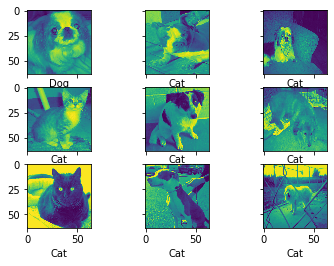

In [275]:
_, ax = plt.subplots(n_row, n_col)
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(X_validation[resnet_samples[i * n_col + j]].reshape(IMG_SIZE, IMG_SIZE))
        ax[i, j].label_outer()
        label = "Cat" if float(tf.math.argmax(predictions[resnet_samples[i * n_col + j]])) == 0.0 else "Dog"
        ax[i, j].set_xlabel(label)
plt.show()